In [1]:
import numpy as np
import pandas as pd
import json as j
import urllib
import gzip
import nltk

nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
!pip install gensim
from gensim.models import KeyedVectors
from nltk.corpus import stopwords

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inzim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Using TensorFlow backend.


In [2]:
import re
#import sys  

#reload(sys)  
#sys.setdefaultencoding('utf8')


import string
from sklearn.feature_extraction.text import CountVectorizer
def clean_text(text):
    #text = [w.strip() for w in text.readlines()]
    #text.decode('unicode_escape').encode('ascii','ignore')
    text = str(text)
    #text = text.decode("utf8")
    
    text =  text.split()
    words = []
    for word in text:
      exclude = set(string.punctuation)
      word = ''.join(ch for ch in word if ch not in exclude)
      if word in stops:
        continue
      try: 
        words.append(ps.stem(word))
      except UnicodeDecodeError:
        words.append(word)
    text = " ".join(words)
    
    
    return text.lower()


#Process data

stops = set(stopwords.words("english"))

ps = PorterStemmer()



f = pd.read_csv("data.csv")  

f.label = f.label.map(dict(REAL=1, FAKE=0))

f

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1


In [3]:
f = f[1:100]

X_train, X_test, y_train, y_test = train_test_split(f['title'], f.label, test_size=0.2)

X_cleaned_train = [clean_text(x) for x in X_train]

X_cleaned_test = [clean_text(x) for x in X_test]



X_cleaned_train[0]


'2016 interview socrat anoth day life empir are near endgam fool ever ‘hope change’ 6 '

In [4]:
import tokenize
from keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_cleaned_train + X_cleaned_test)
print('Finished Building Tokenizer')

train_sequence = tokenizer.texts_to_sequences(X_cleaned_train)
print('Finished Tokenizing Training')

test_sequence = tokenizer.texts_to_sequences(X_cleaned_test)
print('Finished Tokenizing Training')

Finished Building Tokenizer
Finished Tokenizing Training
Finished Tokenizing Training


In [6]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

nb_words = min(20000, len(word_index))

embedding_matrix = np.zeros((nb_words, 300))


for word, i in word_index.items():
    try:
      embedding_vector = word2vec.word_vec(word)
      if embedding_vector is not None and i < 7000:
        embedding_matrix[i] = embedding_vector
    except (KeyError, IndexError) as e:
      continue

Found 606 unique tokens


In [7]:
from keras.models import Sequential

from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

kVECTORLEN = 50

model = Sequential()
model.add(Embedding(5000, 500, input_length=50))
model.add(LSTM(125))
model.add(Dropout(0.4))
model.add(Dense(1, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


#test_sequence

train_sequence = sequence.pad_sequences(train_sequence, maxlen=50)
test_sequence = sequence.pad_sequences(test_sequence, maxlen=50)

history = model.fit(train_sequence, y_train, validation_data=(test_sequence, y_test), epochs=20, batch_size=64)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 500)           2500000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 125)               313000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 126       
Total params: 2,813,126
Trainable params: 2,813,126
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\inzim\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 79 samples, validate on 20 samples
Epoch 1/20
79/79 [==============================] - 12s 153ms/step - loss: 4.0638 - accuracy: 0.4051 - val_loss: 0.9384 - val_accuracy: 0.5000
Epoch 2/20
79/79 [==============================] - 0s 4ms/step - loss: 1.0843 - accuracy: 0.4051 - val_loss: 0.6503 - val_accuracy: 0.6000
Epoch 3/20
79/79 [==============================] - 0s 4ms/step - loss: 0.6417 - accuracy: 0.5949 - val_loss: 0.7132 - val_accuracy: 0.6500
Epoch 4/20
79/79 [==============================] - 0s 4ms/step - loss: 1.2701 - accuracy: 0.7215 - val_loss: 0.6749 - val_accuracy: 0.6500
Epoch 5/20
79/79 [==============================] - 0s 4ms/step - loss: 0.6649 - accuracy: 0.8101 - val_loss: 0.5775 - val_accuracy: 0.6500
Epoch 6/20
79/79 [==============================] - 0s 4ms/step - loss: 0.4968 - accuracy: 0.7595 - val_loss: 0.5993 - val_accuracy: 0.7000
Epoch 7/20
79/79 [==============================] - 0s 4ms/step - loss: 0.5022 - accuracy: 0.7215 - val_loss: 0.6

In [8]:
scores = model.evaluate(test_sequence, y_test, verbose=0)
accuracy = (scores[1]*100)

print("Accuracy: {:.2f}%".format(scores[1]*100))



Accuracy: 70.00%


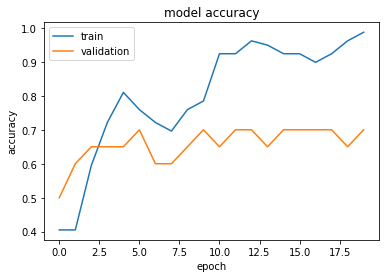

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

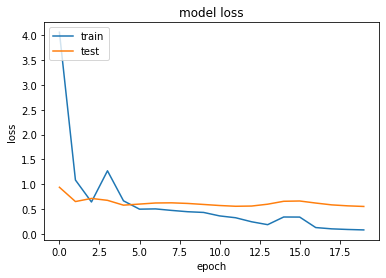

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()